# Project: Employee Sentiment Analysis
## Task 1: Sentiment Labeling
- Using the test.csv dataset, leverage a LLM to perform sentiment analysis on each message in the dataset. Augment the dataset to contain each message's sentiment label.

### Methodology:
1. Use a pretrained hugging face LLM model to perform sentiment analysis on each message in the employee message database.

 -> decided to use "cardiffnlp/twitter-roberta-base-sentiment" from HuggingFace library because it is capable of classifying 3 sentiment classes: positive, negative, and neutral. This model is also simple and can capture casual language well since it was trained on twitter tweets data.
2. First, load necessary libaries, modules, tools, and the data into a pandas dataframe.
3. Next, conduct text preprocessing. This invovles combining the subject and message column into a comprehensive message column that will be fed for sentiment analysis into the LLM. Also, removed any NaNs/empty messages, ensure string datatype within the data, trimmed long texts, and cleaned extra spaces/URLs from the 'message' column.
4. Feed a list of messages in batches to the LLM sentiment analyzer, store the results in a list, and then add that list to a column called 'sentiment' in the dataframe

In [17]:
from transformers import pipeline

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_analyzer = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

In [20]:
# loading the data file into a dataframe
df = pd.read_csv('/content/drive/MyDrive/test(in).csv')

In [21]:
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [22]:
# data preprocessing: combining the subject and body columns into a comprehensive message column for analysis
df['message'] = df['Subject'].fillna('') + "\n\n" + df['body'].fillna('')
df.head()

,Subject,body,date,from,message
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update!\n\nEnronOptions Announcem...
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject)\n\nMarc,\n\nUnfortunately, today ..."
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham\n...
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email\n\nwe were thinking papa...
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet\n\nSince you never gave me the $20 for the...


In [23]:
# text preprocessing: removing NaNs/empty messages, ensuring string datatype, trimming long texts, cleaning extra spaces/URLs

import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df = df[df['message'].notna()]
df = df[df['message'].str.strip() != '']
df['message'] = df['message'].astype(str)
df['message'] = df['message'].str.slice(0, 512)
df['message'] = df['message'].apply(clean_text)

In [24]:
# split and analyze the data
batch_size = 64 # run the sentiment analyzer in batches of 64 rows of data for faster performance

# create a label mapping
label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

# defined a function to output the sentiment of a message
def batch_sentiment_mapped(texts):
    results = sentiment_analyzer(texts)
    return [label_map[res['label']] for res in results]

# put the results in a new column of our df called sentiment
sentiments = []

# run the function on each batch of our dataframe
for i in tqdm(range(0, len(df), batch_size)):
    batch = df['message'][i:i+batch_size].tolist()
    try:
        sentiments.extend(batch_sentiment_mapped(batch))
    except Exception as e:
        print(f"Error on batch {i}-{i+batch_size}: {e}")
        sentiments.extend(['error'] * len(batch))

# create a new column in our dataframe containing the sentiment of each message
df['sentiment'] = sentiments


100%|██████████| 35/35 [10:14<00:00, 17.56s/it]


In [25]:
 # inspect the df
df.head()

,Subject,body,date,from,message,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral


In [26]:
# save the df to a new csv named sentiment_df
df.to_csv('sentiment_df.csv', index=False)

## Task 2: Exporatory Data Analysis
- Understand the structure, distribution, and trends in the dataset through thorough exploration:

### Methodology:
 - examine overall data structure
 - investigate the distribution of sentiment labels
 - analyze trends over time
 - explore additional patterns or anomalies
 - prepare visualizations

In [27]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/sentiment_df.csv')
sentiment_df.head()

,Subject,body,date,from,message,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral


In [28]:
# 1. examining overall structure of the dataframe:
# missing values
sentiment_df.isnull().any()

,0
Subject,False
body,False
date,False
from,False
message,False
sentiment,False


- overall, no missing data or entries

In [29]:
# examine the dimensions of the dataframe (rows, columns)
sentiment_df.shape

(2191, 6)

- dimensions of the dataframe are 2191 rows and 6 columns (subject, body, date, from, message, and sentiment)

In [30]:
# summary statistics of the dataframe
sentiment_df.describe()

,Subject,body,date,from,message,sentiment
count,2191,2191,2191,2191,2191,2191
unique,1251,1539,690,10,1534,3
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com,(No Subject),neutral
freq,141,21,9,284,27,1430


Findings from the summary statistics:
- Total emails: 2,191
- Most common subject: “(No Subject)” (141 times)
- Most frequent sender: [lydia.delgado@enron.com](mailto:lydia.delgado@enron.com) (284 emails)
- Most emails sent on: 7/1/2011 (9 emails)
- Most common sentiment: *Neutral* (1,430 emails, \~65%)
- Frequent message content: Many are empty or repeated
- Unique senders: Only 10 employees in total

In [31]:
# data types of columns in the dataframe
sentiment_df.dtypes

,0
Subject,object
body,object
date,object
from,object
message,object
sentiment,object


- all object datatypes

In [32]:
# distribution of sentiment labels
df['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
neutral,0.652670
positive,0.280694
negative,0.066636


Sentiment distribution:
- Neutral: 65.3% of all messages

- Positive: 28.1% of all messages

- Negative: 6.7% of all messages

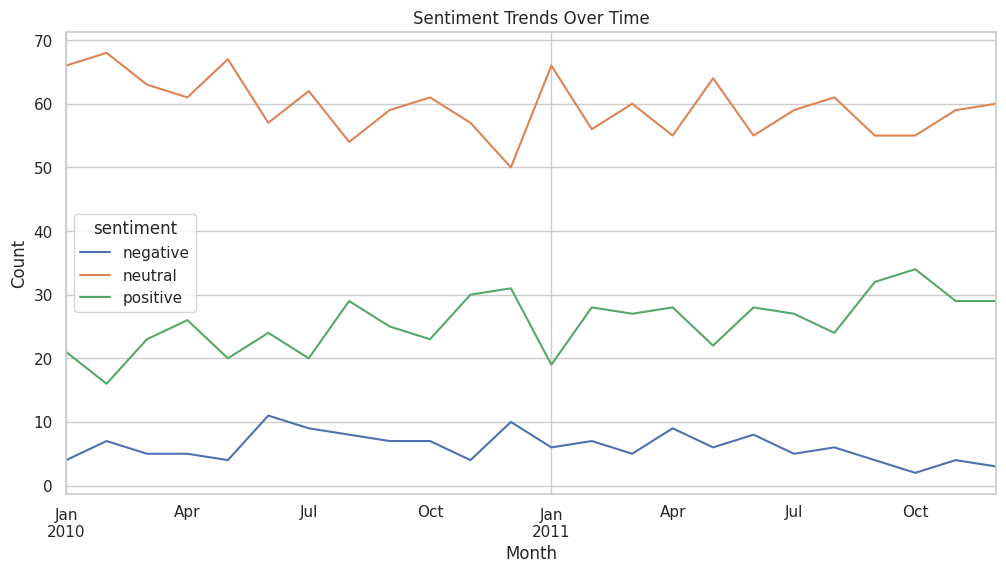

In [33]:
# analyze sentiment trends over time
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.groupby(df['date'].dt.to_period("M"))['sentiment'].value_counts().unstack().plot(kind='line', figsize=(12,6))
plt.title("Sentiment Trends Over Time")
plt.ylabel("Count")
plt.xlabel("Month")
plt.show()

- Neutral Sentiment dominates throughout the year ranging for 50-68 messages per month.
- Positive Sentiment follows next with an upward trend overall, starts around 20 per month and ends ~30 messages per month.
- Negative sentiment is consistently low rarely exceeding 10 messages per month, but occasionally spikes (June/December).

In [34]:
# exploring additional patters:
# 1. sentiment by sender: see if some senders are consistenly more positive/negative/neutral
df.groupby('from')['sentiment'].value_counts(normalize=True).unstack().sort_values('negative', ascending=False).head(10)

sentiment,negative,neutral,positive
from,,,
kayne.coulter@enron.com,0.091954,0.609195,0.298851
bobette.riner@ipgdirect.com,0.087558,0.635945,0.276498
patti.thompson@enron.com,0.080000,0.662222,0.257778
john.arnold@enron.com,0.078125,0.648438,0.273438
sally.beck@enron.com,0.074890,0.616740,0.308370
johnny.palmer@enron.com,0.065728,0.577465,0.356808
rhonda.denton@enron.com,0.052326,0.738372,0.209302
don.baughman@enron.com,0.051643,0.718310,0.230047
lydia.delgado@enron.com,0.049296,0.669014,0.281690


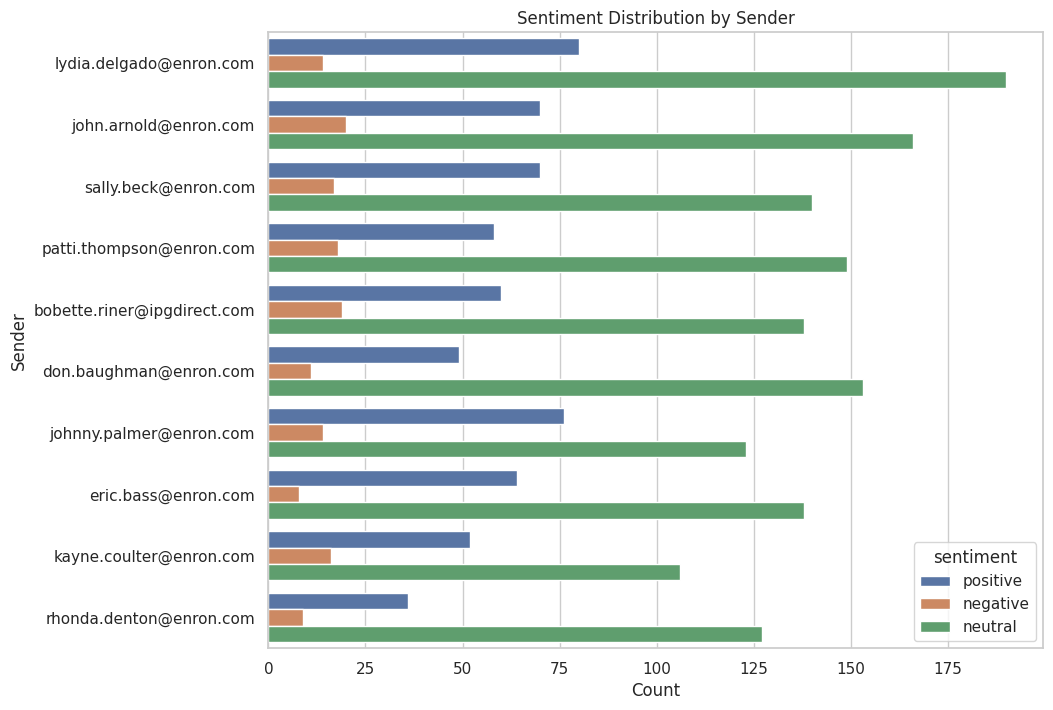

In [35]:
# Visualize previous cell:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, y='from', hue='sentiment', order=df['from'].value_counts().index)
plt.title("Sentiment Distribution by Sender")
plt.xlabel("Count")
plt.ylabel("Sender")
plt.show()

- Kayne Coulter and Bobette Riner have the highest proportions of negative messages (~9%), suggesting they may express more dissatisfaction or concern in communication.

- Eric Bass shows the lowest negative sentiment (~3.8%) and a relatively high positive rate (~30%), indicating a more upbeat communication tone.

- Overall, most top senders still have neutral as their dominant sentiment, with varying levels of positive and negative tone.

- This pattern may suggest personality-driven or role-based differences in communication style across employees.

In [36]:
# get the most common subject lines for each sentiment
top_subjects_by_sentiment = (
    df.groupby('sentiment')['Subject']
    .value_counts()
    .groupby(level=0)
    .head(5)
    .reset_index(name='count')
)

top_subjects_by_sentiment

,sentiment,Subject,count
0,negative,(No Subject),11
1,negative,Re:,8
2,negative,MAPP ATC Posting Website,3
3,negative,MISO proposed $1000 penalty,3
4,negative,"Out of the Office - Friday, October 20",3
5,neutral,(No Subject),102
6,neutral,Re:,42
7,neutral,RE:,13
8,neutral,Interview Schedule,9
9,neutral,Master Power Contracts,8


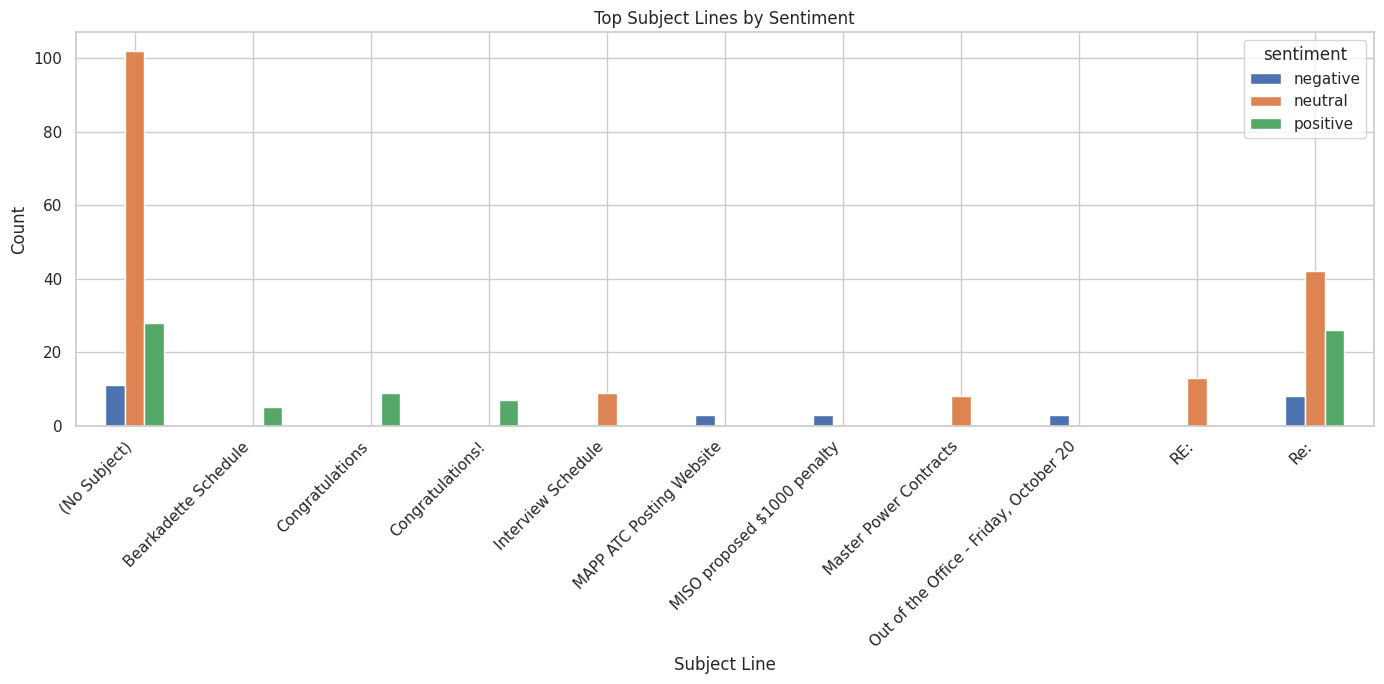

In [37]:
# visualizing previous cell
top_subjects_pivot = top_subjects_by_sentiment.pivot_table(
    index='Subject', columns='sentiment', values='count', fill_value=0
)

# Plotting
top_subjects_pivot.plot(kind='bar', figsize=(14, 7))
plt.title('Top Subject Lines by Sentiment')
plt.xlabel('Subject Line')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- "(No Subject)" and "Re:" are the most common across all sentiments, indicating a prevalence of reply chains or undeclared topics in emails.

- Negative Sentiment:
Common subjects relate to issues or absences, e.g., “MISO proposed $1000 penalty” and “Out of the Office.”

- Neutral Sentiment:
Dominated by routine or procedural topics, like “Interview Schedule” and “Master Power Contracts.”

- Positive Sentiment:
Includes more congratulatory or celebratory messages like “Congratulations” and “Bearkadette Schedule.”

## Task 3: Employee Score Calculation
- Compute a monthly sentiment score for each employee based on their messages
- For each employee:
 - positive message: +1
 - negative message: -1
 - neutral message: 0 (no effect)

### Methodlogy:
1. Create a separate sentiment score column
2. Create a separate month column in the dataframe using the 'date' column
3. Perform a groupby 'month' and 'from', and do a sum() on the sentiment_score column
4. View the results

In [38]:
# observe the number of employees (from senders) in the data
# 10 employees in the dataset
sentiment_df['from'].nunique()

10

In [39]:
# Map sentiment labels to scores
score_map = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

sentiment_df['sentiment_score'] = sentiment_df['sentiment'].map(score_map)
sentiment_df.head()

,Subject,body,date,from,message,sentiment,sentiment_score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative,-1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral,0
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral,0


In [40]:
# ensure date column is datetime
sentiment_df['date_parsed'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# extract month and year for grouping
sentiment_df['month'] = sentiment_df['date_parsed'].dt.to_period('M')


In [41]:
# group by sender and month, then sum sentiment scores
monthly_scores = sentiment_df.groupby(['from', 'month'])['sentiment_score'].sum().reset_index()

# renaming columns for better clarity
monthly_scores.columns = ['employee_email', 'month', 'monthly_sentiment_score']
monthly_scores.head()


,employee_email,month,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,0
1,bobette.riner@ipgdirect.com,2010-02,3
2,bobette.riner@ipgdirect.com,2010-03,0
3,bobette.riner@ipgdirect.com,2010-04,1
4,bobette.riner@ipgdirect.com,2010-05,2


In [42]:
# sorting our dataframe by month and employee + viewing results
display(monthly_scores.sort_values(by=['employee_email', 'month']))

,employee_email,month,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,0
1,bobette.riner@ipgdirect.com,2010-02,3
2,bobette.riner@ipgdirect.com,2010-03,0
3,bobette.riner@ipgdirect.com,2010-04,1
4,bobette.riner@ipgdirect.com,2010-05,2
...,...,...,...
235,sally.beck@enron.com,2011-08,0
236,sally.beck@enron.com,2011-09,0
237,sally.beck@enron.com,2011-10,4
238,sally.beck@enron.com,2011-11,3


## Task 4: Employee Ranking

**Objectives:**
- Generate a ranked list of employees based on their monthly sentiment scores

- Create two distinct lists:
 - top three positive employees: the three employees with the highest positive scores in a given month.
 -  top three negative employees: the three employees with the lowest (most negative) scores in each month
- Sort in descending then alphabetical order
- Present rankings in a table

### Methodology:
1. Define a function that takes in a dataframe. This function creates new dataframes called top_positive, and top_negatives that contain the top 3 positive and negative employees and their scores.
2. From the monthly_scores dataframe, group this df by month, then apply the function.

In [43]:
def rank_monthly_employees(df):
    # for each month, get top 3 positive and top 3 negative
    top_positive = df.sort_values(
        by=['monthly_sentiment_score', 'employee_email'],
        ascending=[False, True]
    ).head(3)
    top_positive['rank_type'] = 'Top Positive'

    top_negative = df.sort_values(
        by=['monthly_sentiment_score', 'employee_email'],
        ascending=[True, True]
    ).head(3)
    top_negative['rank_type'] = 'Top Negative'

    return pd.concat([top_positive, top_negative])

In [44]:
# apply the ranking function to each month's data
ranked_df = (
    monthly_scores
    .groupby('month')
    .apply(rank_monthly_employees)
    .reset_index(drop=True)
)

<ipython-input-44-3229415686>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rank_monthly_employees)


In [45]:
# display the monthly rankings
for month in ranked_df['month'].unique():
    print(f"\n Rankings for {month}")
    display(ranked_df[ranked_df['month'] == month][['rank_type', 'employee_email', 'monthly_sentiment_score']])


 Rankings for 2010-01


,rank_type,employee_email,monthly_sentiment_score
0,Top Positive,lydia.delgado@enron.com,4
1,Top Positive,eric.bass@enron.com,3
2,Top Positive,kayne.coulter@enron.com,3
3,Top Negative,bobette.riner@ipgdirect.com,0
4,Top Negative,john.arnold@enron.com,0
5,Top Negative,rhonda.denton@enron.com,0



 Rankings for 2010-02


,rank_type,employee_email,monthly_sentiment_score
6,Top Positive,bobette.riner@ipgdirect.com,3
7,Top Positive,don.baughman@enron.com,3
8,Top Positive,johnny.palmer@enron.com,3
9,Top Negative,john.arnold@enron.com,-1
10,Top Negative,kayne.coulter@enron.com,-1
11,Top Negative,sally.beck@enron.com,-1



 Rankings for 2010-03


,rank_type,employee_email,monthly_sentiment_score
12,Top Positive,sally.beck@enron.com,5
13,Top Positive,eric.bass@enron.com,3
14,Top Positive,john.arnold@enron.com,3
15,Top Negative,bobette.riner@ipgdirect.com,0
16,Top Negative,don.baughman@enron.com,0
17,Top Negative,kayne.coulter@enron.com,0



 Rankings for 2010-04


,rank_type,employee_email,monthly_sentiment_score
18,Top Positive,john.arnold@enron.com,5
19,Top Positive,kayne.coulter@enron.com,4
20,Top Positive,lydia.delgado@enron.com,3
21,Top Negative,eric.bass@enron.com,0
22,Top Negative,bobette.riner@ipgdirect.com,1
23,Top Negative,johnny.palmer@enron.com,1



 Rankings for 2010-05


,rank_type,employee_email,monthly_sentiment_score
24,Top Positive,eric.bass@enron.com,4
25,Top Positive,sally.beck@enron.com,4
26,Top Positive,patti.thompson@enron.com,3
27,Top Negative,don.baughman@enron.com,0
28,Top Negative,john.arnold@enron.com,0
29,Top Negative,johnny.palmer@enron.com,0



 Rankings for 2010-06


,rank_type,employee_email,monthly_sentiment_score
30,Top Positive,don.baughman@enron.com,5
31,Top Positive,sally.beck@enron.com,5
32,Top Positive,johnny.palmer@enron.com,2
33,Top Negative,kayne.coulter@enron.com,-2
34,Top Negative,bobette.riner@ipgdirect.com,0
35,Top Negative,eric.bass@enron.com,0



 Rankings for 2010-07


,rank_type,employee_email,monthly_sentiment_score
36,Top Positive,eric.bass@enron.com,3
37,Top Positive,lydia.delgado@enron.com,3
38,Top Positive,sally.beck@enron.com,3
39,Top Negative,john.arnold@enron.com,-1
40,Top Negative,rhonda.denton@enron.com,-1
41,Top Negative,kayne.coulter@enron.com,0



 Rankings for 2010-08


,rank_type,employee_email,monthly_sentiment_score
42,Top Positive,sally.beck@enron.com,9
43,Top Positive,john.arnold@enron.com,3
44,Top Positive,rhonda.denton@enron.com,3
45,Top Negative,bobette.riner@ipgdirect.com,-2
46,Top Negative,patti.thompson@enron.com,0
47,Top Negative,eric.bass@enron.com,1



 Rankings for 2010-09


,rank_type,employee_email,monthly_sentiment_score
48,Top Positive,bobette.riner@ipgdirect.com,4
49,Top Positive,patti.thompson@enron.com,4
50,Top Positive,sally.beck@enron.com,3
51,Top Negative,don.baughman@enron.com,-1
52,Top Negative,kayne.coulter@enron.com,0
53,Top Negative,john.arnold@enron.com,1



 Rankings for 2010-10


,rank_type,employee_email,monthly_sentiment_score
54,Top Positive,lydia.delgado@enron.com,8
55,Top Positive,bobette.riner@ipgdirect.com,3
56,Top Positive,eric.bass@enron.com,3
57,Top Negative,patti.thompson@enron.com,-3
58,Top Negative,don.baughman@enron.com,0
59,Top Negative,kayne.coulter@enron.com,0



 Rankings for 2010-11


,rank_type,employee_email,monthly_sentiment_score
60,Top Positive,bobette.riner@ipgdirect.com,6
61,Top Positive,john.arnold@enron.com,5
62,Top Positive,patti.thompson@enron.com,3
63,Top Negative,don.baughman@enron.com,1
64,Top Negative,johnny.palmer@enron.com,1
65,Top Negative,kayne.coulter@enron.com,1



 Rankings for 2010-12


,rank_type,employee_email,monthly_sentiment_score
66,Top Positive,john.arnold@enron.com,7
67,Top Positive,lydia.delgado@enron.com,4
68,Top Positive,bobette.riner@ipgdirect.com,3
69,Top Negative,don.baughman@enron.com,-1
70,Top Negative,johnny.palmer@enron.com,0
71,Top Negative,eric.bass@enron.com,1



 Rankings for 2011-01


,rank_type,employee_email,monthly_sentiment_score
72,Top Positive,johnny.palmer@enron.com,6
73,Top Positive,eric.bass@enron.com,4
74,Top Positive,don.baughman@enron.com,2
75,Top Negative,kayne.coulter@enron.com,-1
76,Top Negative,patti.thompson@enron.com,-1
77,Top Negative,sally.beck@enron.com,-1



 Rankings for 2011-02


,rank_type,employee_email,monthly_sentiment_score
78,Top Positive,johnny.palmer@enron.com,8
79,Top Positive,john.arnold@enron.com,6
80,Top Positive,kayne.coulter@enron.com,3
81,Top Negative,bobette.riner@ipgdirect.com,-1
82,Top Negative,sally.beck@enron.com,-1
83,Top Negative,eric.bass@enron.com,0



 Rankings for 2011-03


,rank_type,employee_email,monthly_sentiment_score
84,Top Positive,lydia.delgado@enron.com,5
85,Top Positive,patti.thompson@enron.com,5
86,Top Positive,bobette.riner@ipgdirect.com,3
87,Top Negative,johnny.palmer@enron.com,0
88,Top Negative,sally.beck@enron.com,0
89,Top Negative,don.baughman@enron.com,1



 Rankings for 2011-04


,rank_type,employee_email,monthly_sentiment_score
90,Top Positive,bobette.riner@ipgdirect.com,6
91,Top Positive,eric.bass@enron.com,5
92,Top Positive,don.baughman@enron.com,3
93,Top Negative,john.arnold@enron.com,-1
94,Top Negative,kayne.coulter@enron.com,0
95,Top Negative,rhonda.denton@enron.com,0



 Rankings for 2011-05


,rank_type,employee_email,monthly_sentiment_score
96,Top Positive,lydia.delgado@enron.com,5
97,Top Positive,don.baughman@enron.com,3
98,Top Positive,johnny.palmer@enron.com,3
99,Top Negative,john.arnold@enron.com,-1
100,Top Negative,bobette.riner@ipgdirect.com,0
101,Top Negative,eric.bass@enron.com,0



 Rankings for 2011-06


,rank_type,employee_email,monthly_sentiment_score
102,Top Positive,johnny.palmer@enron.com,7
103,Top Positive,eric.bass@enron.com,5
104,Top Positive,bobette.riner@ipgdirect.com,3
105,Top Negative,kayne.coulter@enron.com,-1
106,Top Negative,patti.thompson@enron.com,-1
107,Top Negative,rhonda.denton@enron.com,0



 Rankings for 2011-07


,rank_type,employee_email,monthly_sentiment_score
108,Top Positive,sally.beck@enron.com,5
109,Top Positive,johnny.palmer@enron.com,4
110,Top Positive,patti.thompson@enron.com,4
111,Top Negative,kayne.coulter@enron.com,0
112,Top Negative,lydia.delgado@enron.com,0
113,Top Negative,rhonda.denton@enron.com,1



 Rankings for 2011-08


,rank_type,employee_email,monthly_sentiment_score
114,Top Positive,eric.bass@enron.com,3
115,Top Positive,johnny.palmer@enron.com,3
116,Top Positive,lydia.delgado@enron.com,3
117,Top Negative,sally.beck@enron.com,0
118,Top Negative,don.baughman@enron.com,1
119,Top Negative,kayne.coulter@enron.com,1



 Rankings for 2011-09


,rank_type,employee_email,monthly_sentiment_score
120,Top Positive,eric.bass@enron.com,6
121,Top Positive,johnny.palmer@enron.com,6
122,Top Positive,rhonda.denton@enron.com,5
123,Top Negative,john.arnold@enron.com,0
124,Top Negative,sally.beck@enron.com,0
125,Top Negative,bobette.riner@ipgdirect.com,1



 Rankings for 2011-10


,rank_type,employee_email,monthly_sentiment_score
126,Top Positive,kayne.coulter@enron.com,7
127,Top Positive,lydia.delgado@enron.com,6
128,Top Positive,john.arnold@enron.com,5
129,Top Negative,bobette.riner@ipgdirect.com,0
130,Top Negative,johnny.palmer@enron.com,1
131,Top Negative,rhonda.denton@enron.com,1



 Rankings for 2011-11


,rank_type,employee_email,monthly_sentiment_score
132,Top Positive,kayne.coulter@enron.com,5
133,Top Positive,john.arnold@enron.com,4
134,Top Positive,patti.thompson@enron.com,4
135,Top Negative,rhonda.denton@enron.com,-1
136,Top Negative,lydia.delgado@enron.com,0
137,Top Negative,eric.bass@enron.com,1



 Rankings for 2011-12


,rank_type,employee_email,monthly_sentiment_score
138,Top Positive,kayne.coulter@enron.com,5
139,Top Positive,lydia.delgado@enron.com,5
140,Top Positive,eric.bass@enron.com,3
141,Top Negative,bobette.riner@ipgdirect.com,0
142,Top Negative,don.baughman@enron.com,1
143,Top Negative,johnny.palmer@enron.com,1


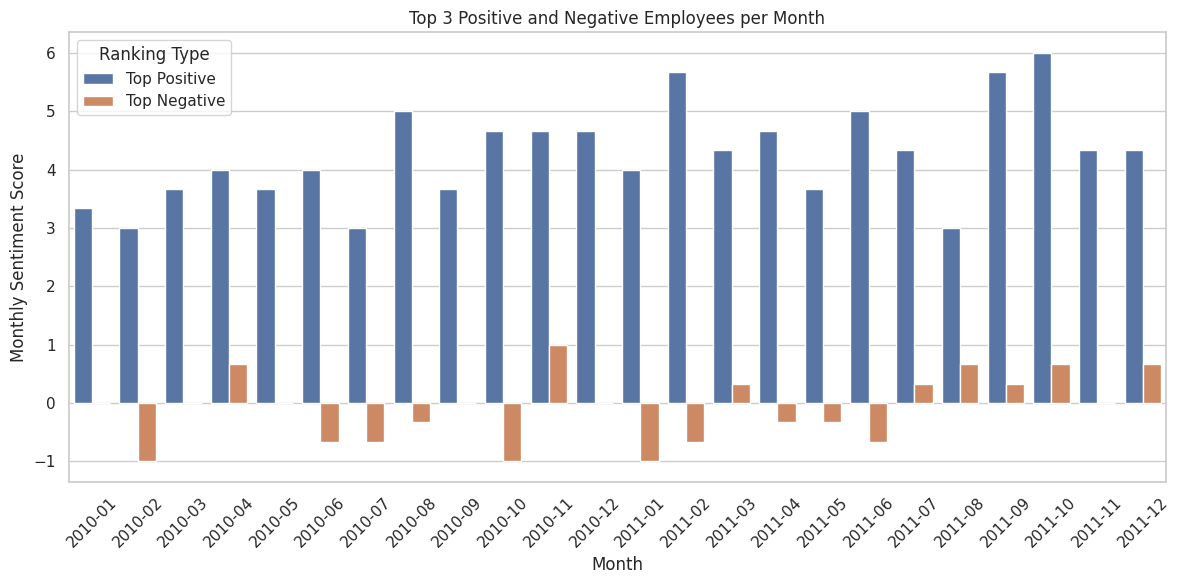

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'month' to string for better x-axis labels
ranked_df['month'] = ranked_df['month'].astype(str)

# Set plot style
sns.set(style="whitegrid")

# Create barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=ranked_df,
    x='month',
    y='monthly_sentiment_score',
    hue='rank_type',
    errorbar = None
)

plt.title('Top 3 Positive and Negative Employees per Month')
plt.ylabel('Monthly Sentiment Score')
plt.xlabel('Month')
plt.legend(title='Ranking Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Task 5: Flight Risk Identification
**Objective:**
- Identify employees who are at risk of leaving based on their monthly sentiment scores.
- A Flight risk is any employee who has sent 4 or more negative mails in the span of 30 days (irrespective of the score).

- The 30-day period is rolling count of days, irrepective of months.

- Extract a list of these employees

- Ensure that this flagging process is robust.

**Methodlogy:**
1. Filter Negative Sentiment:

 - Retain only emails labeled with 'negative' sentiment.

2. Sort Data:

 - Sort the filtered emails by sender and date to prepare for rolling time window analysis.

3. Initialize Storage:

 - Create an empty set to store email addresses of employees flagged as flight risks.

4. Apply Rolling 30-Day Check:

 - For each employee:
   - Extract their list of email dates.
   - Use a rolling window to check if 4 or more negative emails were sent within any 30-day period.
   - If such a window exists, add the employee to the flight risk set.

5. Create Output DataFrame:

 - Convert the flagged senders into a DataFrame.

 - Mark them with a boolean flag (flight_risk = True).

6. Display Results:

 - Present the list of employees identified as potential flight risks.



In [52]:
# filter negative messages only
neg_df = sentiment_df[sentiment_df['sentiment'] == 'negative'].copy()

# sort by sender and date
neg_df = neg_df.sort_values(['from', 'date'])
neg_df['date'] = pd.to_datetime(neg_df['date'])

# initialize a set
flight_risk_employees = set()
neg_df.head()

,Subject,body,date,from,message,sentiment,sentiment_score,date_parsed,month
1760,Harrison,your running backs suck - what do you want for...,2011-01-28,bobette.riner@ipgdirect.com,Harrison your running backs suck - what do you...,negative,-1,2011-01-28,2011-01
654,RE: are trading,volumes are still down - i have no clue on the...,2011-01-09,bobette.riner@ipgdirect.com,RE: are trading volumes are still down - i hav...,negative,-1,2011-01-09,2011-01
1979,"Out of the Office - Friday, October 20",I will be out of the office for most of the da...,2011-11-04,bobette.riner@ipgdirect.com,"Out of the Office - Friday, October 20 I will ...",negative,-1,2011-11-04,2011-11
384,Re:,shut the fuck up!\n\n\n \n\tEnron North Amer...,2010-12-25,bobette.riner@ipgdirect.com,Re: shut the fuck up! Enron North America Corp...,negative,-1,2010-12-25,2010-12
449,RE: Baby Party/Shower,bring the kids.... but they can't have any booze!,2011-02-23,bobette.riner@ipgdirect.com,RE: Baby Party/Shower bring the kids.... but t...,negative,-1,2011-02-23,2011-02


In [53]:
# check rolling 30-day window for each employee
for sender, group in neg_df.groupby('from'):
    dates = group['date'].reset_index(drop=True)
    for i in range(len(dates)):
        window = dates[(dates >= dates[i]) & (dates <= dates[i] + pd.Timedelta(days=30))]
        if len(window) >= 4:
            flight_risk_employees.add(sender)
            break

In [54]:
# creating a new flight_risk_df of our results:
flight_risk_df = pd.DataFrame({'employee_email': list(flight_risk_employees)})
flight_risk_df['flight_risk'] = True

print("Employees flagged as flight risks:")
display(flight_risk_df)

Employees flagged as flight risks:


,employee_email,flight_risk
0,bobette.riner@ipgdirect.com,True
1,don.baughman@enron.com,True
2,patti.thompson@enron.com,True
3,john.arnold@enron.com,True


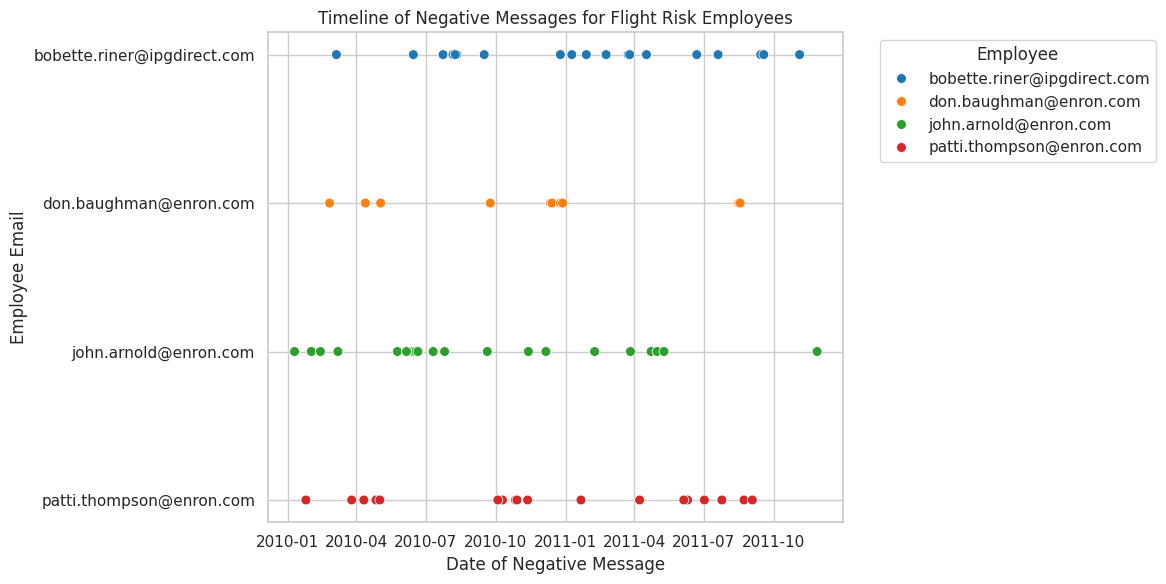

In [57]:
# Filter just the flight risk employees
risk_emails = flight_risk_employees
plot_df = neg_df[neg_df['from'].isin(risk_emails)]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=plot_df, x='date', y='from', hue='from', palette='tab10', s=50)

plt.title("Timeline of Negative Messages for Flight Risk Employees")
plt.xlabel("Date of Negative Message")
plt.ylabel("Employee Email")
plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

##Task 6: Predictive Modeling
**Objective**:
- Develop a linear regression model to analyze sentiment trends and predict sentiment scores using a variety of independent variables that may influence sentiment scores
- Requirements:
 - Select appropriate features from the dataset that may influence sentiment scores
 - Split the data into training and testing sets
 - Develop a linear regression model and validate its effectiveness using suitable metrics
 - Interpret the model results and discuss the significance of the findings.

**Methodology:**
1. Feature Engineering:
 - Added two new columns:
  - word_count: number of words in each message.
  - char_count: number of characters in each message.
2. Aggregate Data on a Monthly Basis:
 - computed for each employee-month:
  - monthly_sentiment_score: Sum of sentiment scores.
  - message_count: Number of messages.
  - avg_word_count: Average words per message.
  - avg_char_count: Average characters per message.
  - total_words: Total word count across all messages.
  - total_chars: Total character count across all messages.
3. Model Preparation:
 - Selected independent variables:
  - message_count, avg_word_count, avg_char_count, total_words, total_chars
 - Defined the target: monthly_sentiment_score.
 - Split data into training and testing sets (80/20 split).
4. Model Training + Prediction:
 - Trained a Linear Regression model using the training set.
 - Made predictions on the test set.
5. Model Evaluation + Analysis:
 - Evaluate using:
  - Mean Squared Error (MSE) to measure prediction error.
  - R-squared (R²) to determine variance explained by the model.
  - Displayed model coefficients to assess influence of each feature on sentiment score.
  - Plotted residuals (actual - predicted) vs. predicted values (used to assess linearity, variance stability, and model fit)

In [58]:
sentiment_df.head()

,Subject,body,date,from,message,sentiment,sentiment_score,date_parsed,month
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive,1,2010-05-10,2010-05
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative,-1,2010-07-29,2010-07
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral,0,2011-07-25,2011-07
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral,0,2010-03-25,2010-03
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral,0,2011-05-21,2011-05


In [59]:
# feature engineering: add word and character count columns for each message:
# Step 1: Add word and character count columns
sentiment_df['word_count'] = sentiment_df['message'].apply(lambda x: len(str(x).split()))
sentiment_df['char_count'] = sentiment_df['message'].apply(lambda x: len(str(x)))
# Count of positive/negative/neutral messages per month
sentiment_df['is_positive'] = sentiment_df['sentiment'] == 'positive'
sentiment_df['is_negative'] = sentiment_df['sentiment'] == 'negative'
sentiment_df['is_neutral'] = sentiment_df['sentiment'] == 'neutral'
sentiment_df.head()

,Subject,body,date,from,message,sentiment,sentiment_score,date_parsed,month,word_count,char_count,is_positive,is_negative,is_neutral
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive,1,2010-05-10,2010-05,74,483,True,False,False
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative,-1,2010-07-29,2010-07,59,320,False,True,False
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral,0,2011-07-25,2011-07,28,188,False,False,True
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral,0,2010-03-25,2010-03,29,171,False,False,True
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral,0,2011-05-21,2011-05,43,199,False,False,True


In [82]:
# aggregate by employee-month:
monthly_df = sentiment_df.groupby(['from', 'month']).agg(
    monthly_sentiment_score=('sentiment_score', 'sum'),
    message_count=('message', 'count'),
    avg_word_count=('word_count', 'mean'),
    avg_char_count=('char_count', 'mean'),
    total_words=('word_count', 'sum'),
    total_chars=('char_count', 'sum'),
    positive_msg_count=('is_positive', 'sum'),
    negative_msg_count=('is_negative', 'sum'),
    neutral_msg_count=('is_neutral', 'sum')
).reset_index()

monthly_df['positive_ratio'] = monthly_df['positive_msg_count'] / monthly_df['message_count']
monthly_df['negative_ratio'] = monthly_df['negative_msg_count'] / monthly_df['message_count']
monthly_df['neutral_ratio'] = monthly_df['neutral_msg_count'] / monthly_df['message_count']

monthly_df.head()

,from,month,monthly_sentiment_score,message_count,avg_word_count,avg_char_count,total_words,total_chars,positive_msg_count,negative_msg_count,neutral_msg_count,positive_ratio,negative_ratio,neutral_ratio
0,bobette.riner@ipgdirect.com,2010-01,0,2,24.500000,153.500000,49,307,0,0,2,0.000000,0.000000,1.000000
1,bobette.riner@ipgdirect.com,2010-02,3,14,39.071429,242.857143,547,3400,3,0,11,0.214286,0.000000,0.785714
2,bobette.riner@ipgdirect.com,2010-03,0,11,40.818182,247.000000,449,2717,1,1,9,0.090909,0.090909,0.818182
3,bobette.riner@ipgdirect.com,2010-04,1,6,32.500000,222.833333,195,1337,1,0,5,0.166667,0.000000,0.833333
4,bobette.riner@ipgdirect.com,2010-05,2,4,31.250000,177.500000,125,710,2,0,2,0.500000,0.000000,0.500000


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# --- Model Prep ---
features = [
    'message_count', 'avg_word_count', 'avg_char_count',
    'total_words', 'total_chars',
    'positive_ratio', 'negative_ratio', 'neutral_ratio'
]
target = 'monthly_sentiment_score'

# Check for NaNs before modeling
monthly_df = monthly_df.dropna(subset=features + [target])

# Define X and y
X = monthly_df[features]
y = monthly_df[target]

# --- Outlier Removal ---
z_scores = np.abs(zscore(y))
no_outlier_indices = np.where(z_scores < 3)[0]

X_no_outliers = X.iloc[no_outlier_indices]
y_no_outliers = y.iloc[no_outlier_indices]

# --- Train/Test Split + Scaling ---
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 1.54
R-squared (R²): 0.61


- MSE measures the average squared difference between the predicted sentiment values and the actual sentiment values. Lower MSE means your predictions are closer to the real values.
 - An MSE of 3.60 indicates that on average, the squared error per prediction is 3.60 for monthly sentiment scores.
- R² indicates how much of the variability in the actual sentiment scores your model explains.
 - An R² of 0.30 means your model explains 30% of the variance in sentiment scores, while the remaining 70% is unexplained or due to noise/other factors.
 - This means the model performs moderatly but is missing a lot of important information/complexity.

In [90]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Feature Importance:")
print(coefficients)

Feature Importance:
          Feature  Coefficient
3     total_words     2.813157
2  avg_char_count     1.217551
5  positive_ratio     0.668986
0   message_count     0.507701
7   neutral_ratio    -0.313344
6  negative_ratio    -0.694885
1  avg_word_count    -1.329575
4     total_chars    -2.280806


- message_count: Most impactful positive predictor (coefficient = **0.116**)
- avg_word_count: Small positive effect (coefficient = **0.010**)
- total_words: Minimal positive impact (coefficient = **0.002**)
- avg_char_count: Small negative effect (coefficient = **-0.001**)
- total_chars: Negligible negative effect (coefficient ≈ **0**)


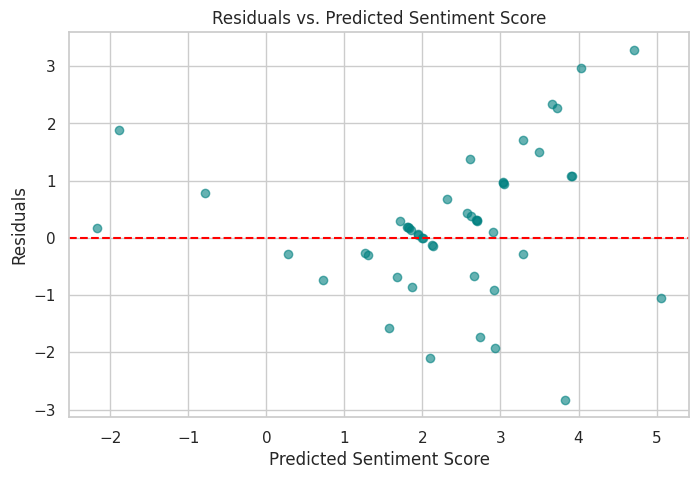

In [92]:
# evaluate the residuals of our predictions:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6, color='teal')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Predicted Sentiment Score")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Sentiment Score")
plt.grid(True)
plt.show()

Residual Plot Analysis:
- No clear pattern: The residuals are scattered somewhat randomly around the red horizontal line (residual = 0), which is good — it suggests the model errors are mostly unbiased.
- Some outliers: There are a few points where residuals are >3 or < -3, which may be outliers or points the model fails to predict well.

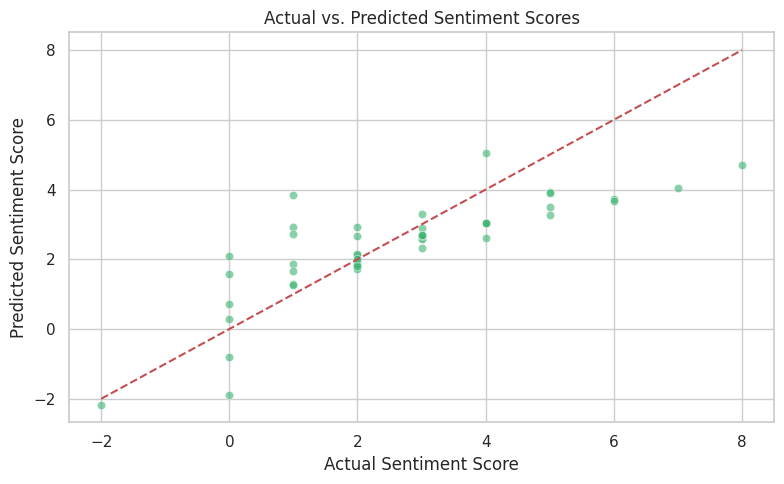

In [93]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs. Predicted Sentiment Scores")
plt.grid(True)
plt.tight_layout()
plt.show()